In [7]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('ggplot')

# Train 

Load training features set:

In [8]:
train_data = pd.read_csv("../data/train_data.csv.gz", compression="gzip", encoding="utf8")
train_data.head()

,author,subreddit,created_utc,body
0,Shamus_Aran,mylittlepony,1.388534e+09,I don't think we'd get nearly as much fanficti...
1,Riddance,sex,1.388534e+09,"Thanks. I made it up, that's how I got over my..."
2,Secret_Wizard,DragonsDogma,1.388534e+09,Are you sure you aren't confusing Cyclops (the...
3,Penultimatum,malefashionadvice,1.388534e+09,dont do this to me bro
4,7-SE7EN-7,todayilearned,1.388534e+09,That's what we do when we can't find a mate


In [9]:
print("Number of users (train):", train_data.author.unique().shape[0])

Number of users (train): 5000


Load training targets:

In [10]:
target = pd.read_csv("../data/train_target.csv")
target.head()

,author,gender
0,RedThunder90,0
1,Lirkmor,1
2,In0chi,0
3,ProjectGrudge,0
4,TehTurtleHermit,0


# Feature Extraction

### Subreddits

We extract the subreddit for each message:

In [11]:
subreddits = train_data.subreddit.unique()
subreddits_map = pd.Series(index=subreddits, data=np.arange(subreddits.shape[0]))

Extract subreddits for each user and store results in a sparse matrix X. Each row of X represents an user, and each column a subreddit. If user $i$ published something in subreddit $j$, then $X_{ij}$ will be 1, otherwise is 0.

In [12]:
def extract_features(group):
    
    group_subreddits = group['subreddit'].values
    idxs = subreddits_map[group_subreddits].values
    v = sparse.dok_matrix((1, subreddits.shape[0]))
    
    for idx in idxs:
        if not np.isnan(idx):
            v[0, idx] = 1
        
    return v.tocsr()

In [13]:
features_dict = {}
for author, group in train_data.groupby('author'):
    features_dict[author] = extract_features(group)
    
X = sparse.vstack([features_dict[author] for author in target.author])
print("Number of users:", X.shape[0])
print("Number of subreddits:", X.shape[1])

Number of users: 5000
Number of subreddits: 3468


### Body 

We extract the body of messages of each user:

In [14]:
def extract_text(group):
    group_text = group['body'].values
    return " ".join(str(v) for v in group_text)

In [15]:
text_dict = {}
for author, group in train_data.groupby('author'):
    text_dict[author] = extract_text(group)
    
author_text = [text_dict[author] for author in target.author]

Trasform messages using "Term Frequency Inverse Document Frequency" (tfidf) method and we store results in a sparse matrix $X_{train}$. We do not considered most common words ("stop words"). Each row of $X_{train}$ represents a user and each column represents a word. The element $X_{train}(i,j)$ represent the tfidf weight for user $i$ for word $j$.

In [16]:
cv = CountVectorizer(stop_words='english')
C = cv.fit_transform(author_text)

tfidf = TfidfTransformer(sublinear_tf=True)

X_train = tfidf.fit_transform(C)
print("Number of users:", X_train.shape[0])
print("Number of words:", X_train.shape[1])

Number of users: 5000
Number of words: 148717


We extract also the target for the training set:

In [17]:
y = target.gender
print('Target Length:', len(y))

Target Length: 5000


# Model Selection

Since data have different nature (subreddits and body message) we train two different models.

### Subreddit Model

We first consider a Logistic Regression Model. We use Cross validation to tune  the regularization parameter C. In particular we consider the area under the ROC curve for scoring (http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score):

In [18]:
model_subreddit_lg = LogisticRegression()
Cs = np.logspace(-3,1,100)
gs_subreddit_lg = GridSearchCV(model_subreddit_lg, param_grid={'C':Cs}, cv = 10, scoring = 'roc_auc', n_jobs = -1, verbose = True)
gs_subreddit_lg.fit(X, y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   11.0s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-03,   1.09750e-03, ...,   9.11163e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

Results of Cross Validation:

/home/nicolo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Best C: 0.739072203353
Best CV score: 0.894883681737


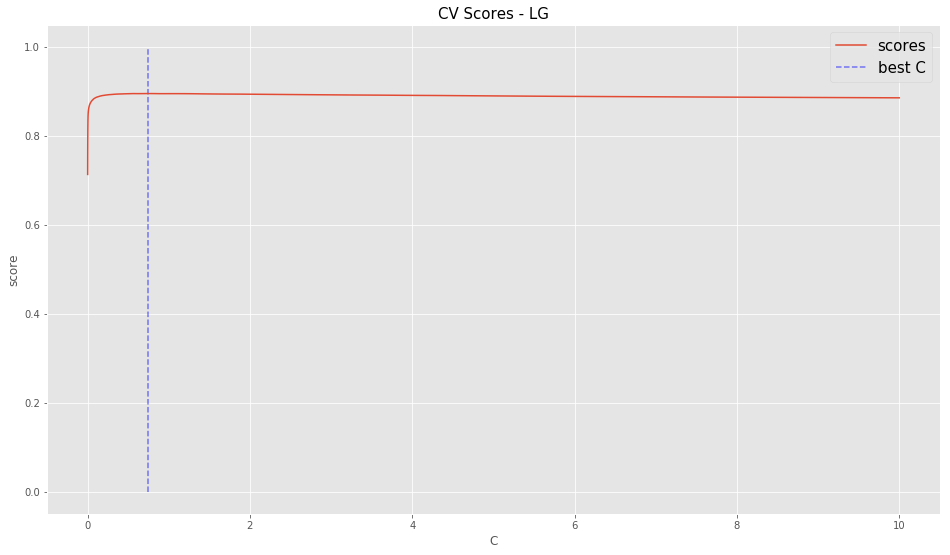

In [19]:
best_C = gs_subreddit_lg.best_params_
scores = [g.mean_validation_score for g in gs_subreddit_lg.grid_scores_]
plt.figure(figsize = (16,9))
plt.plot(Cs, scores, label = 'scores')
plt.vlines(x = best_C['C'], ymin = 0, ymax = 1, alpha = 0.5, linestyle = '--', color = 'blue', label = 'best C')
plt.title('CV Scores - LG', size = 15)
plt.xlabel('C')
plt.ylabel('score')
plt.legend(fontsize = 15)
print('Best C:', best_C['C'])
print('Best CV score:', gs_subreddit_lg.best_score_)

We try also with a Random Forest. In this case cross validation becomes harder since there is more than one parameter to tune:

In [20]:
model_subreddit_rf = RandomForestClassifier(n_estimators=100)
param_grid = {'max_depth':[1,5,10,20,30,40],
              'max_features': [1,5,10,30]}
gs_subreddit_rf = GridSearchCV(model_subreddit_rf, param_grid=param_grid, cv = 5, scoring = 'roc_auc', n_jobs = -1, verbose = True)
gs_subreddit_rf.fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   30.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 5, 10, 20, 30, 40], 'max_features': [1, 5, 10, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

Best Parameters: {'max_depth': 30, 'max_features': 10}
Best CV score: 0.886492303967


/home/nicolo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


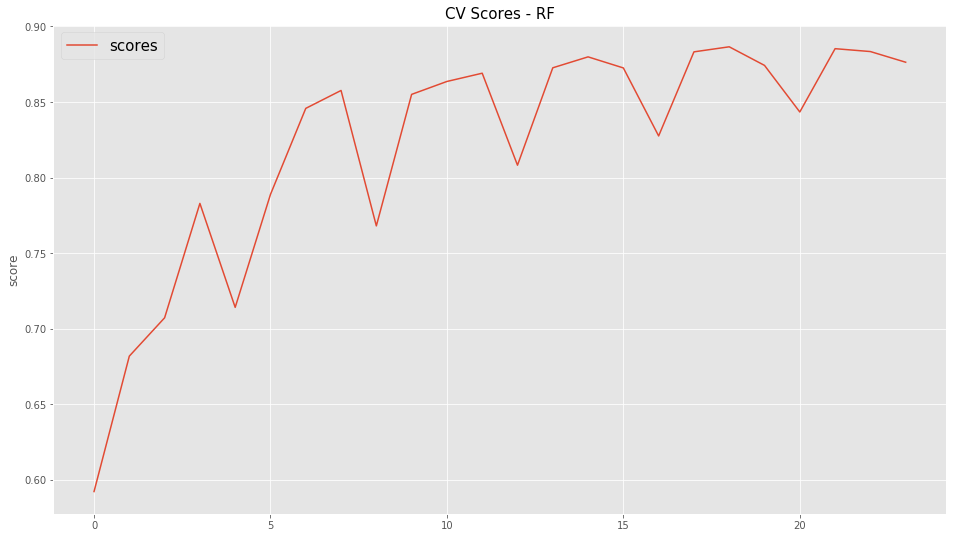

In [21]:
scores = [g.mean_validation_score for g in gs_subreddit_rf.grid_scores_]
plt.figure(figsize = (16,9))
plt.plot(scores, label = 'scores')
plt.title('CV Scores - RF', size = 15)
plt.ylabel('score')
plt.legend(fontsize = 15)
print('Best Parameters:', gs_subreddit_rf.best_params_)
print('Best CV score:', gs_subreddit_rf.best_score_)

We consider Logistic Regression as the final model for subreddit features:

In [22]:
gs_subreddit = gs_subreddit_lg

### Messages

For text analysis of messages submitted by users we try with a Naive Bayes model:

In [23]:
alphas = np.logspace(-3,-1, num = 10) 
model_body = MultinomialNB()
gs_body = GridSearchCV(model_body, param_grid={'alpha':alphas}, cv = 10, scoring = 'roc_auc', verbose = True, n_jobs=-1)
gs_body.fit(X_train, y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.9s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': array([ 0.001  ,  0.00167,  0.00278,  0.00464,  0.00774,  0.01292,
        0.02154,  0.03594,  0.05995,  0.1    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

Results of Cross Validation:

/home/nicolo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Best alpha: 0.0215443469003
Best CV score: 0.866043007333


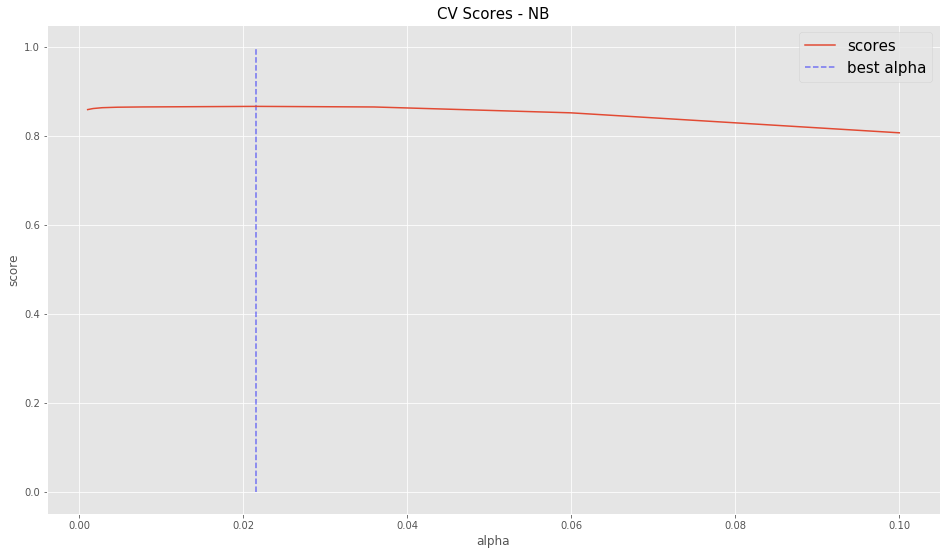

In [24]:
best_alpha = gs_body.best_params_
scores = [g.mean_validation_score for g in gs_body.grid_scores_]
plt.figure(figsize = (16,9))
plt.plot(alphas, scores, label = 'scores')
plt.vlines(x = best_alpha['alpha'], ymin = 0, ymax = 1, alpha = 0.5, linestyle = '--', color = 'blue', label = 'best alpha')
plt.title('CV Scores - NB', size = 15)
plt.xlabel('alpha')
plt.ylabel('score')
plt.legend(fontsize = 15)
print('Best alpha:', best_alpha['alpha'])
print('Best CV score:', gs_body.best_score_)

### Combine results

Finally we have to combine results of the two models. We may think at the outputs of the two models as new inputs for a third model. We scatter the two predictions and we color points according to the output:

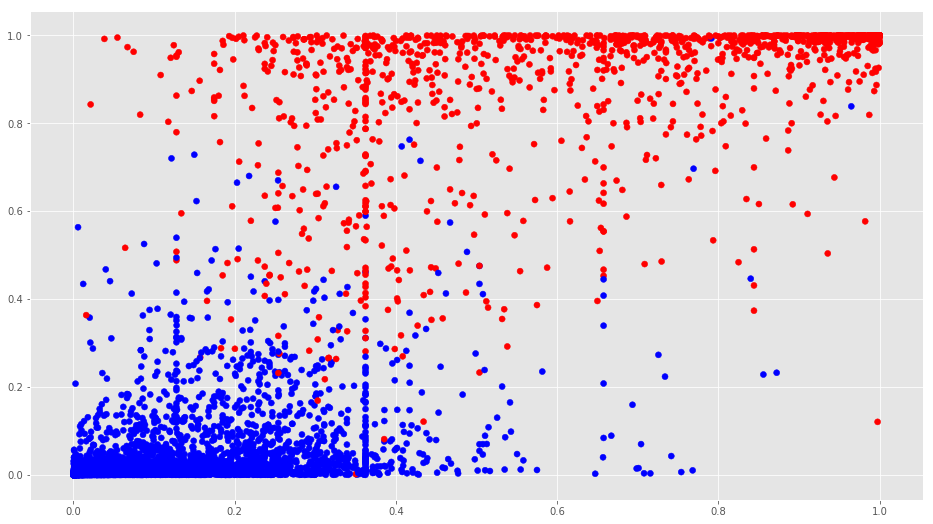

In [25]:
y_subreddit = gs_subreddit.predict_proba(X)[:,1]
y_body = gs_body.predict_proba(X_train)[:,1]
col = ['b' if el == 0 else 'r' for el in y]
plt.figure(figsize = (16,9))
plt.scatter(y_subreddit,y_body, color = col, marker = 'o')

It looks like a problem suitable for a Support Vector Machine. First we rescale features between -1 and 1:

In [26]:
X_combined = [[y1, y2] for y1, y2 in zip(y_subreddit, y_body)]
X_combined = np.array(X_combined)
scaler = MinMaxScaler(feature_range = (-1, 1))
X_combined = scaler.fit_transform(X_combined)

Then we train a SVM model with linear kernel and we tune the regularization parameter through cross validation:

In [33]:
SVM = svm.SVC(kernel = 'linear', probability=True)
Cs = np.logspace(-2,1,100)
gs = GridSearchCV(SVM, param_grid = {'C':Cs}, cv = 3, scoring = 'roc_auc', n_jobs=-1, verbose = True)
gs.fit(X_combined, y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   13.7s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': array([  0.01   ,   0.01072, ...,   9.32603,  10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

Results of Cross Validation:

Best C: 0.0327454916288
Best CV score: 0.998024474523


/home/nicolo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


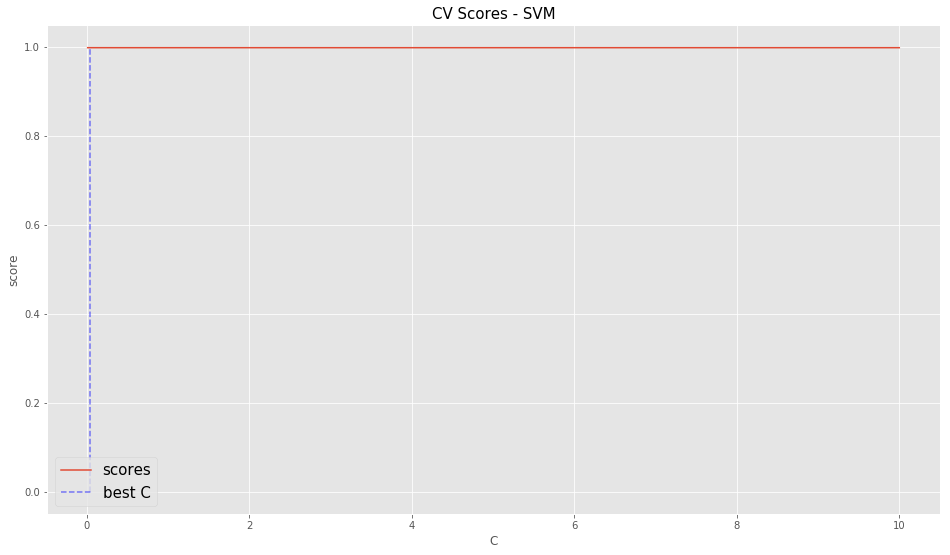

In [34]:
best_C = gs.best_params_
scores = [g.mean_validation_score for g in gs.grid_scores_]
plt.figure(figsize = (16,9))
plt.plot(Cs, scores, label = 'scores')
plt.vlines(x = best_C['C'], ymin = 0, ymax = 1, alpha = 0.5, linestyle = '--', color = 'blue', label = 'best C')
plt.title('CV Scores - SVM', size = 15)
plt.xlabel('C')
plt.ylabel('score')
plt.legend(fontsize = 15)
print('Best C:', best_C['C'])
print('Best CV score:', gs.best_score_)

# Test

We load and preprocess test data:

In [35]:
test_data = pd.read_csv("../data/test_data.csv", encoding="utf8")
authors_test = test_data.author.unique()
test_data.head()

,author,subreddit,created_utc,body
0,ejchristian86,TwoXChromosomes,1.388534e+09,I hadn't ever heard of them before joining thi...
1,ZenDragon,gaming,1.388534e+09,"At 7680 by 4320 with 64x AA, right?"
2,savoytruffle,AskReddit,1.388534e+09,bite me
3,hentercenter,stlouisblues,1.388534e+09,Damn that was a good penalty :(
4,rick-o-suave,army,1.388534e+09,I swore into DEP on 6-OCT and I left 5-NOV und...


- Subreddits:

In [36]:
features_dict = {}

for author, group in test_data.groupby('author'):
    features_dict[author] = extract_features(group)
    
X = sparse.vstack([features_dict[author] for author in authors_test])
print("Number of users:", X.shape[0])
print("Number of subreddits:", X.shape[1])

Number of users: 15000
Number of subreddits: 3468


- Messages:

In [37]:
text_dict = {}

for author, group in test_data.groupby('author'):
    text_dict[author] = extract_text(group)
    
author_text = [text_dict[author] for author in authors_test]
C = cv.transform(author_text)
X_test = tfidf.transform(C)

We prepare the final solution:

In [38]:
y_subreddit = gs_subreddit.predict_proba(X)[:,1]
y_body = gs_body.predict_proba(X_test)[:,1]
X_combined = [[y1, y2] for y1, y2 in zip(y_subreddit, y_body)]
X_combined = np.array(X_combined)
X_combined = scaler.transform(X_combined)
predictions = gs.predict_proba(X_combined)[:,1]

In [39]:
solution = pd.DataFrame({"author":authors_test, "gender":predictions})
solution.head()

,author,gender
0,ejchristian86,1.000000
1,ZenDragon,0.000980
2,savoytruffle,0.001067
3,hentercenter,0.001446
4,rick-o-suave,0.007470


In [ ]:
solution.to_csv("solution.csv", index=False)